In [1]:
]activate .

  Activating project at `~/Dropbox/Prgm/Julia/MonteCarloCollisions/examples`


In [2]:
]dev ..

   Resolving package versions...
  No Changes to `~/Dropbox/Prgm/Julia/MonteCarloCollisions/examples/Project.toml`
  No Changes to `~/Dropbox/Prgm/Julia/MonteCarloCollisions/examples/Manifest.toml`


In [3]:
using MonteCarloCollisions
using Statistics, BenchmarkTools, StaticArrays, Plots

In [4]:
# set up the background interacting species.
# Neutrals(name, temperature (K), mass (kg), number density (m^-3)
helium = Neutrals("helium", 300., 4*amu, 1e23);
argon = Neutrals("argon", 300., 40*amu, 1e22);

In [5]:
# and the primary simulated species
# Particles(name, mass (kg), charge (C), number of particles)
electrons = Particles("electron", m_e, q_e, 10000);

In [6]:
# Create `Interactions` object from the cross section data downloaded from LXCat
helium_interaction_list = load_interactions_lxcat("../data/CS_e_He_Phelps.txt", electrons, helium);
argon_interaction_list = load_interactions_lxcat("../data/CS_e_Ar_Phelps.txt", electrons, argon);
electron_interactions = make_interactions(electrons, vcat(helium_interaction_list, argon_interaction_list));

In [7]:
# Start simulation with thermal electrons at T = 10000 K
init_thermal(electrons, 10000)

# reset their simulation time
init_time(electrons)

# set external electrostatic field at 1000 V/m in x direction
E = SVector(1000., 0., 0.);

In [8]:
# Currently MonteCarloCollisions provides advance! method to advance the particles in time by a fixed time
# To simulate the time evolution and the equilibrium distribution, we need to write a loop

# tax are times where all ions are synchronized and their energies sampled
tax = range(0, 1e-6, length=101)

# these arrays accumulate the data for statistics
Emeans = zeros(length(tax))
energies = []

# for t > t_equilib, we assume that equilibrium was reached and we start
# accumulating the electron energies
t_equilib = 5e-7


for i in 1:size(tax,1)
    advance!(electrons, electron_interactions, E, tax[i])
    Emeans[i] = mean(energy(electrons))
    if tax[i] >= t_equilib
        append!(energies, energy(electrons))
    end
end

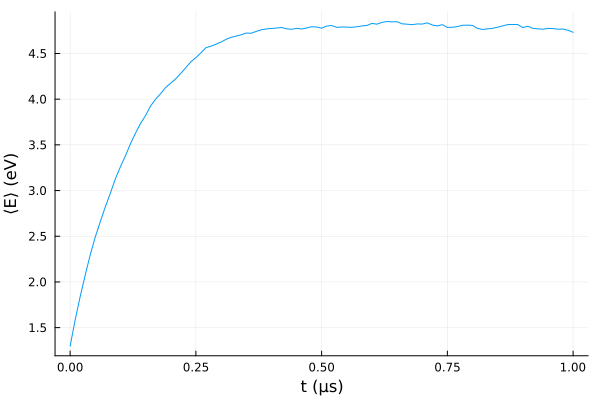

In [9]:
# plot the energy time evolution t confirm that equilibrium is reached after t_equilib
plot(tax ./ 1e-6, Emeans ./ q_e, label="", xlabel="t (μs)", ylabel="⟨E⟩ (eV)")

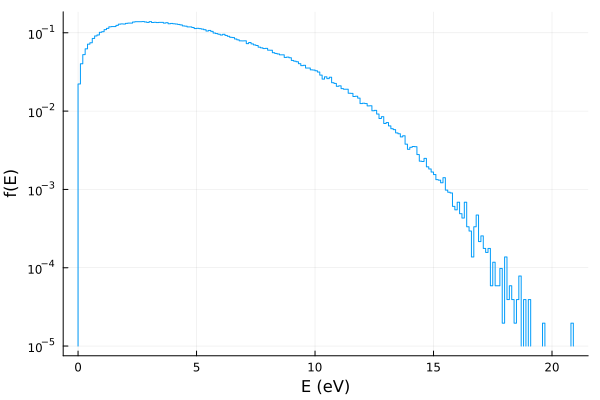

In [10]:
# the electron energy distribution function
stephist(energies ./ q_e, normalize=:pdf,
        label="",
        yaxis=:log,
        xlabel="E (eV)",
        ylabel="f(E)",
        yticks=10. .^ (-5:-1))

In [11]:
# and the primary simulated species
# Particles(name, mass (kg), charge (C), number of particles)
electrons = Particles("electron", m_e, q_e, 100);

# Start simulation with thermal electrons at T = 10000 K
init_thermal(electrons, 10000)

# Now let's add perpendicular magnetic field in y direction
# and scan the magnetic field magnitude in range
Bax = 10. .^ range(-4,log10(0.2), length=16)

# these arrays accumulate the data for statistics
Emeans = zeros(length(Bax))

# tax are times where all ions are synchronized and their energies sampled
tax = range(0, 40e-6, length=101)

# for t > t_equilib, we assume that equilibrium was reached and we start
# accumulating the electron energies
t_equilib = 60e-7

for j in 1:size(Bax, 1)
    println("By = ", Bax[j])
    # reset their simulation time
    init_time(electrons)
    energies = []
    
    for i in 1:size(tax, 1)
        B = SVector(0., Bax[j], 0.)
        advance!(electrons, electron_interactions, E, B, tax[i])
        
        if tax[i] >= t_equilib
            append!(energies, mean(energy(electrons)))
        end
    end
    Emeans[j] = mean(energies)
end

By = 0.0001
By = 0.00016598493257629447
By = 0.00027550997842357025
By = 0.00045730505192732656
By = 0.0007590574821095607
By = 0.0012599210498948727
By = 0.002091279105182546
By = 0.0034712082127193837
By = 0.005761682611465066
By = 0.009563524997900372
By = 0.015874010519681993
By = 0.02634846565824805
By = 0.04373448295773113
By = 0.07259265204998101
By = 0.12049286456050502
By = 0.20000000000000004


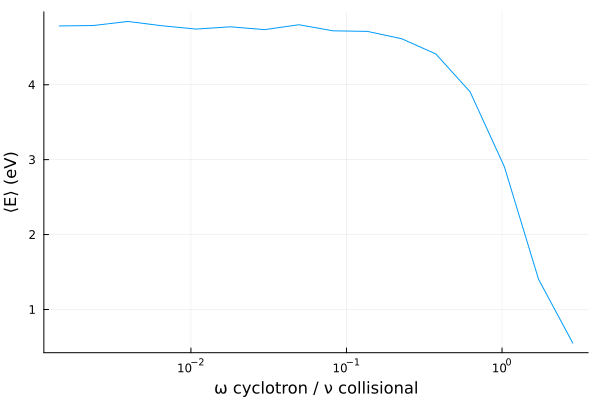

In [12]:
# a plot to show that the electron mean energy is not influenced by the magnetic field
# if the cyclotron frequency is much smaller than the collision frequency
plot(
    Bax*q_e/m_e / electron_interactions.rate,
    Emeans ./ q_e,
    label="",
    xaxis=:log,
    xlabel="ω cyclotron / ν collisional",
    ylabel="⟨E⟩ (eV)"
)